Notebook for model optimisation 

In [2]:
! pip install -q tensorflow-model-optimization

In [3]:
#allow file access
from google.colab import files

from tensorflow.keras.models import load_model

import pickle

#import shap  
#import shap
#shap.initjs()

import pandas as pd
import tensorflow as tf
#tf.compat.v1.disable_v2_behavior() #this was required for SHAP values
#possibly worth using the below 
#tf.compat.v1.enable_eager_executionconfig=None, device_policy=None, execution_mode=None)
from tensorflow import keras


#borrowed form 5c16
from keras import datasets
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

from keras.models import model_from_json


from tensorflow.keras.callbacks import CSVLogger

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

import pickle
import sklearn as skl

#r2 score
#from keras import backend as K
import tensorflow.keras.backend as K
from sklearn.metrics import r2_score

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

#model optimisation api
import tensorflow_model_optimization as tfmot

import tempfile
import os
import zipfile

%load_ext tensorboard

from tabulate import tabulate

In [4]:
# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        self.metrics = []
        self.val_metrics = []
        

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('r_squared'))
        self.val_acc.append(logs.get('val_r_squared'))
        ###
        self.metrics.append(logs.get('mean_absolute_percentage_error'))         #mean_squared_error
        self.val_metrics.append(logs.get('val_mean_absolute_percentage_error')) #val_mean_squared_error
        
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(60, 20))
        plt.plot([3, 1])

        #plot 1 mean absolute percentage error
        plt.subplot(131) 
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('Mse')
        plt.xlabel('epoch')
        plt.title('MSE Value')
        plt.legend()

        #plot 2 r squared value
        plt.subplot(133)         
        plt.plot(self.x, self.acc, label="training r-squared")
        plt.plot(self.x, self.val_acc, label="validation r-squared")
        plt.legend()
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('R-squared')
        plt.xlabel('epoch')
        plt.title('R-Squared Value')

        #plot 3 mean squared error
        plt.subplot(132)         
        plt.plot(self.x, self.metrics, label="training mse")
        plt.plot(self.x, self.val_metrics, label="validation mse")
        plt.legend()
        plt.ylabel('Mean absolute percentage Error')
        plt.xlabel('epoch')
        plt.title('Mean absolute percentage Error')
        
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();
        

#creating a r^2 metric for the model evaluation
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

    

In [5]:
ch_names = np.arange(44).tolist()
freqs = np.arange(191.6, 195.9, 0.1).tolist()
for x in range(len(ch_names)):
  ch_names[x] = "Ch %.0f (%.1f)" % (ch_names[x], freqs[x])

In [6]:
#generate the train and validation datasets
#retreiving both datasets from GitHub
git_xval = 'https://raw.githubusercontent.com/p-owens/MAI/main/x_val.csv'
git_yval = 'https://raw.githubusercontent.com/p-owens/MAI/main/y_val.csv'
df_x = pd.read_csv(git_xval,
                  index_col=False,
                  header=None,
                  names=ch_names)

df_y = pd.read_csv(git_yval,
                  index_col=False,
                  header=None,
                  names=ch_names)

#dropping the frequences row for each training sample
df_x = df_x.iloc[1::2]
#print(df_x)

In [7]:
#set the channel number here
channel = 39

In [9]:
#drop all rows where df_x has a value != 0
df_chx = df_x[df_x[ch_names[channel]] !=0]
df_chy = df_y[df_y[ch_names[channel]] !=0]
df_chy = df_chy[ch_names[channel]]

#convert to numpy arrays
x_values = df_chx.to_numpy()
y_values = df_chy.to_numpy()


val_split = .2

#generate the test/validation split
#x_rem, x_test, y_rem, y_test = skl.model_selection.train_test_split(x_values, y_values, test_size=.2, random_state=0)
x_train, x_val, y_train, y_val = skl.model_selection.train_test_split(x_values, y_values, test_size = val_split, random_state = 0)#renaimed x_rem and y_rem to x_values and y_values


In [10]:
print(x_train.shape[0])

5045


In [11]:
#Using a dataset with 1 ch constantly on for the test set
#retreiving both datasets from GitHub



git_xval = ('https://raw.githubusercontent.com/p-owens/MAI/main/data%20gen/ch{0}/x_val.csv'.format(channel))
git_yval = ('https://raw.githubusercontent.com/p-owens/MAI/main/data%20gen/ch{0}/y_val.csv'.format(channel))
dfx = pd.read_csv(git_xval,
                  index_col=False,
                  header=None,
                  names=ch_names                                   
                 )
dfy = pd.read_csv(git_yval,
                  index_col=False,
                  header=None,
                  names=ch_names
                 )

#dropping the frequences row for each training sample
dfx = dfx.iloc[1::2]

#drop all rows where df_x has a value != 0
dfx = dfx[dfx[ch_names[channel]] !=0]
dfy = dfy[dfy[ch_names[channel]] !=0]
dfy = dfy[ch_names[channel]]

x_test = dfx.to_numpy()
y_test = dfy.to_numpy()

In [15]:
#loading a previously saved model

model_dir = "ch_39_mse_0.27_pct_err_5.63.h5"

l_rate = 1 * 1e-4
opt = tf.keras.optimizers.Nadam(learning_rate=l_rate)

model = tf.keras.models.load_model(model_dir, custom_objects={'r_squared': r_squared})
model.compile(optimizer=opt,
                       loss='mean_squared_error',
                       metrics=[r_squared, tf.keras.metrics.MeanAbsolutePercentageError()])

model.summary()


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
dense_48 (Dense)             (None, 360)               16200     
_________________________________________________________________
dropout_40 (Dropout)         (None, 360)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 180)               64980     
_________________________________________________________________
dropout_41 (Dropout)         (None, 180)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 180)               32580     
_________________________________________________________________
dropout_42 (Dropout)         (None, 180)               0   

In [16]:
#evaluating the loaded model


results = model.evaluate(x_test,y_test)#, verbose=1)
print("{name1}\t\t: {mse:<.4f}\t(lower is better)\n{name2}\t: {percent_err:<.3%}\t(lower is better)".format(name1 = model.metrics_names[0],
                                                                                                    name2 = model.metrics_names[2],
                                                                                                    mse = results[0],
                                                                                                    percent_err = results[2]/100))



13/13 [==============================] - 0s 3ms/step - loss: 0.2122 - r_squared: 0.9150 - mean_absolute_percentage_error: 5.1738
loss		: 0.2103	(lower is better)
mean_absolute_percentage_error	: 5.159%	(lower is better)


In [ ]:
"""
#callback for plotting the model metrics

#csv logger file
log_file = 'model_ch_{0}.csv'.format(ch)
csv_log = CSVLogger(log_file)

pltCallBack = PlotLossAccuracy()
#callback for saving the model
checkpoint = ModelCheckpoint(filepath='model_checkpoints/ep_{epoch:02d}_mse_{val_loss:.2f}_r2_{val_r_squared:.2f}.hdf5',
                             monitor='val_loss',
                             verbose=0,
                             save_weights_only=False,
                             save_best_only=True,
                             mode='min',
                             save_freq="epoch")

batchSize = 512

# and train
model.fit(x_train, y_train,
                    batch_size=batchSize, epochs=100, 
                    validation_data=(x_val, y_val), 
                    callbacks=[pltCallBack, checkpoint])
"""

In [ ]:
'''
#Quantisation Aware training

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=[r_squared])

q_aware_model.summary()
'''

In [ ]:
"""
#saving a model
keras_file = "baseline_model.h5"
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)
"""

In [ ]:
print(pd.DataFrame(x_test))
print(pd.DataFrame(y_test))

In [25]:
#pruning the model

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

epochs_prune = 200
batch_size = 400
#validation_split = val_size # 10% of training set will be used for validation set. 

num_images = x_test.shape[0] * (1 - val_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs_prune


"""          
pruning_params = {'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=0.95,
                                                                            begin_step=0,
                                                                            end_step = end_step)}
"""                                                                            

# Define model for pruning - polynomial decay.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)}                                                            
                                                     

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate=l_rate / 2),
              loss='mean_squared_error',
              metrics=[r_squared, tf.keras.metrics.MeanAbsolutePercentageError()])

model_for_pruning.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
prune_low_magnitude_dense_48 (None, 360)               32042     
_________________________________________________________________
prune_low_magnitude_dropout_ (None, 360)               1         
_________________________________________________________________
prune_low_magnitude_dense_49 (None, 180)               129782    
_________________________________________________________________
prune_low_magnitude_dropout_ (None, 180)               1         
_________________________________________________________________
prune_low_magnitude_dense_50 (None, 180)               64982     
_________________________________________________________________
prune_low_magnitude_dropout_ (None, 180)               1   

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


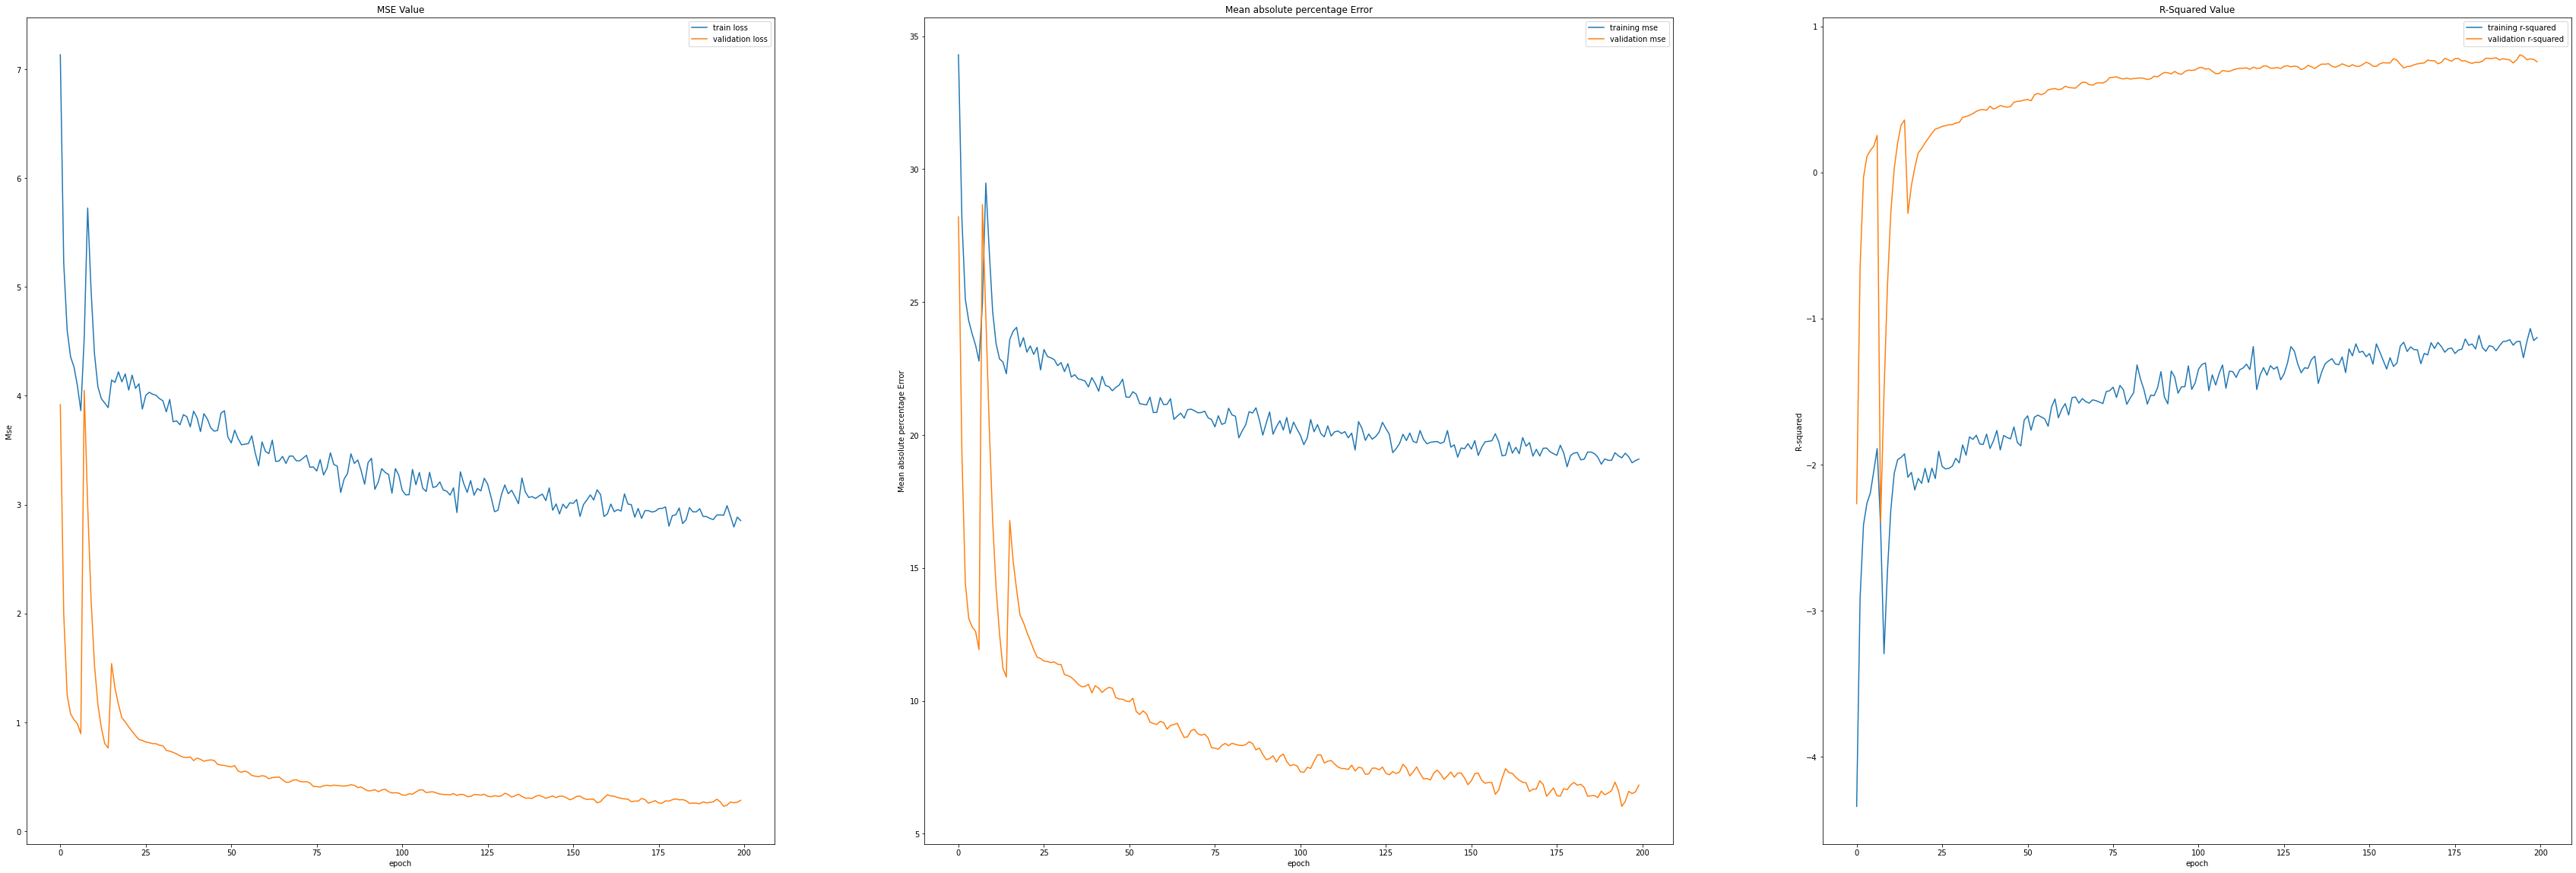

In [26]:
logdir = tempfile.mkdtemp()
log_file = "model_ch_{0}.csv".format(channel)
csv_log = CSVLogger(log_file)
pltCallBack = PlotLossAccuracy()

callbacks = [tfmot.sparsity.keras.UpdatePruningStep(),
             tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
             pltCallBack,
             csv_log]
  
model_for_pruning.fit(x_train,
                      y_train,
                      batch_size=batch_size,
                      verbose=1,
                      epochs=epochs_prune, 
                      validation_data=(x_val, y_val), 
                      callbacks=callbacks)

In [27]:
#print the logfile of the model training data
pd.read_csv(log_file, index_col='epoch')

,loss,mean_absolute_percentage_error,r_squared,val_loss,val_mean_absolute_percentage_error,val_r_squared
epoch,,,,,,
0,7.132041,34.302135,-4.339036,3.919029,28.206415,-2.267737
1,5.222826,28.129919,-2.917725,2.000291,19.337976,-0.656223
2,4.603770,25.105526,-2.412731,1.252568,14.438399,-0.034315
3,4.358051,24.292845,-2.265152,1.077939,13.097658,0.108008
4,4.264822,23.803230,-2.194406,1.024795,12.784023,0.149751
...,...,...,...,...,...,...
195,2.990533,19.315405,-1.268728,0.241074,6.216961,0.794029
196,2.894273,19.182449,-1.159359,0.267951,6.594770,0.771137
197,2.794712,18.955130,-1.068919,0.261596,6.511355,0.776550


In [30]:
#Compare pruned model v unpruned model

results_pruned = model_for_pruning.evaluate(x_test,y_test, verbose=1)
print("Baseline Model:\n{name1}\t\t: {mse:<.4f}\t(lower is better)\n{name2}\t: {r2:<.2%}\t(higher is better)".format(name1 = model.metrics_names[0],
                                                                                                    name2 = model.metrics_names[2],
                                                                                                    mse = results[0],
                                                                                                    r2 = results[2]/100))

print("Pruned Model:\n{namep1}\t\t: {pmse:<.4f}\t(lower is better)\n{namep2}\t: {pr2:<.2%}\t(higher is better)".format(namep1 = model_for_pruning.metrics_names[0],
                                                                                                    namep2 = model_for_pruning.metrics_names[2],
                                                                                                    pmse = results_pruned[0],
                                                                                                    pr2 = results_pruned[2]/100))

13/13 [==============================] - 0s 3ms/step - loss: 0.3857 - r_squared: 0.8148 - mean_absolute_percentage_error: 7.2482
Baseline Model:
loss		: 0.2103	(lower is better)
mean_absolute_percentage_error	: 5.16%	(higher is better)
Pruned Model:
loss		: 0.3857	(lower is better)
mean_absolute_percentage_error	: 7.25%	(higher is better)


In [32]:
headings = ["Layer Name", "Total Parameters", "% Zero"]
format_row = "{:<50}" * (len(headings) + 1)

values = []

for i, w in enumerate(model_for_pruning.get_weights()):
    if(w.size > 1 and (np.sum(w == 0) != 0)):
      inner_list = []
      inner_list.append("{}".format({model_for_pruning.weights[i].name}))
      inner_list.append("{}".format(w.size))
      inner_list.append("{:.2f}%".format(np.sum(w == 0) / w.size * 100))
      values.append(inner_list)

print (tabulate(values, headings, numalign='left', tablefmt='rst'))

=======================================  ==================  ========
Layer Name                               Total Parameters    % Zero
=======================================  ==================  ========
{'dense_48/kernel:0'}                    15840               80.00%
{'prune_low_magnitude_dense_48/mask:0'}  15840               80.00%
{'dense_49/kernel:0'}                    64800               80.00%
{'prune_low_magnitude_dense_49/mask:0'}  64800               80.00%
{'dense_50/kernel:0'}                    32400               80.00%
{'prune_low_magnitude_dense_50/mask:0'}  32400               80.00%
{'dense_51/kernel:0'}                    16200               80.00%
{'prune_low_magnitude_dense_51/mask:0'}  16200               80.00%
{'dense_52/kernel:0'}                    4050                80.00%
{'prune_low_magnitude_dense_52/mask:0'}  4050                80.00%
{'dense_53/kernel:0'}                    45                  80.00%
{'prune_low_magnitude_dense_53/mask:0'}  45 

In [ ]:

#docs_infra: no_execute
%tensorboard --logdir={logdir}

In [36]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /tmp/tmpl_8gjp_v.h5


In [37]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

"""
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()
"""

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(tflite_quant_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

INFO:tensorflow:Assets written to: /tmp/tmpr4p7o5ex/assets
Saved pruned TFLite model to: /tmp/tmp3r3jqxmb.tflite


In [38]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.  

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [44]:
#orig = get_gzipped_model_size(keras_file)
reduced = get_gzipped_model_size(pruned_keras_file)
tf_lite = get_gzipped_model_size(pruned_tflite_file)

#print("Size of gzipped baseline Keras model:\t {:,d} bytes".format(orig))
print("Size of gzipped pruned Keras model:\t {:,d} bytes".format(reduced))
#print("Pruning Compression: {:.1%}".format(1 - reduced/orig)) 
print("Size of gzipped pruned TFlite model: {:,d} bytes".format(tf_lite))
#print("Compression: {:.1%}".format(1 - tf_lite/orig)) 


Size of gzipped pruned Keras model:	 163,022 bytes
Size of gzipped pruned TFlite model: 51,416 bytes
